# Extract Absence EEG data from dataset

Extract all the absence EEG data from the dataset, analyse and apply filters. Split into epochs/windows. Export for training.


In [75]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd;
%matplotlib qt

import math

import mne
from mne.filter import notch_filter

import csv

## Load Data From Dataset


In [3]:
# Set data location
DEV_DATA_FOLDER = "E:/edf/dev"

# Set absence data file names from absence_files.txt
ABSENCE_FILES_NAMES = []
with open(r"processed_data\absence\absence_files.txt", "r") as f:
    for i in f.readlines():
        ABSENCE_FILES_NAMES.append(DEV_DATA_FOLDER + i[:-1])


# Change index to change which absence seizure to load
def import_data(seizure_idx):
    raw = mne.io.read_raw_edf(ABSENCE_FILES_NAMES[seizure_idx])
    print(raw.load_data())
    return raw

In [210]:
seizure_idx = 5
raw = import_data(seizure_idx)

Extracting EDF parameters from E:\edf\dev\02_tcp_le\006\00000675\s002_2006_09_05\00000675_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 311249  =      0.000 ...  1244.996 secs...
<RawEDF | 00000675_s002_t001.edf, 41 x 311250 (1245.0 s), ~97.4 MB, data loaded>


## Select n Channels


In [211]:
channels = [0, 1, 2, 3, 4]
excl_channels = raw.info["ch_names"][len(channels) :]
raw.drop_channels(
    excl_channels
)  # Drop channels in excl_channels, keep only channels in channels

Measurement date,"September 05, 2006 11:36:02 GMT"
Experimenter,Unknown
Participant,00000675
Digitized points,Not available
Good channels,5 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.00 Hz
Lowpass,125.00 Hz


## Analyse and Filter Data


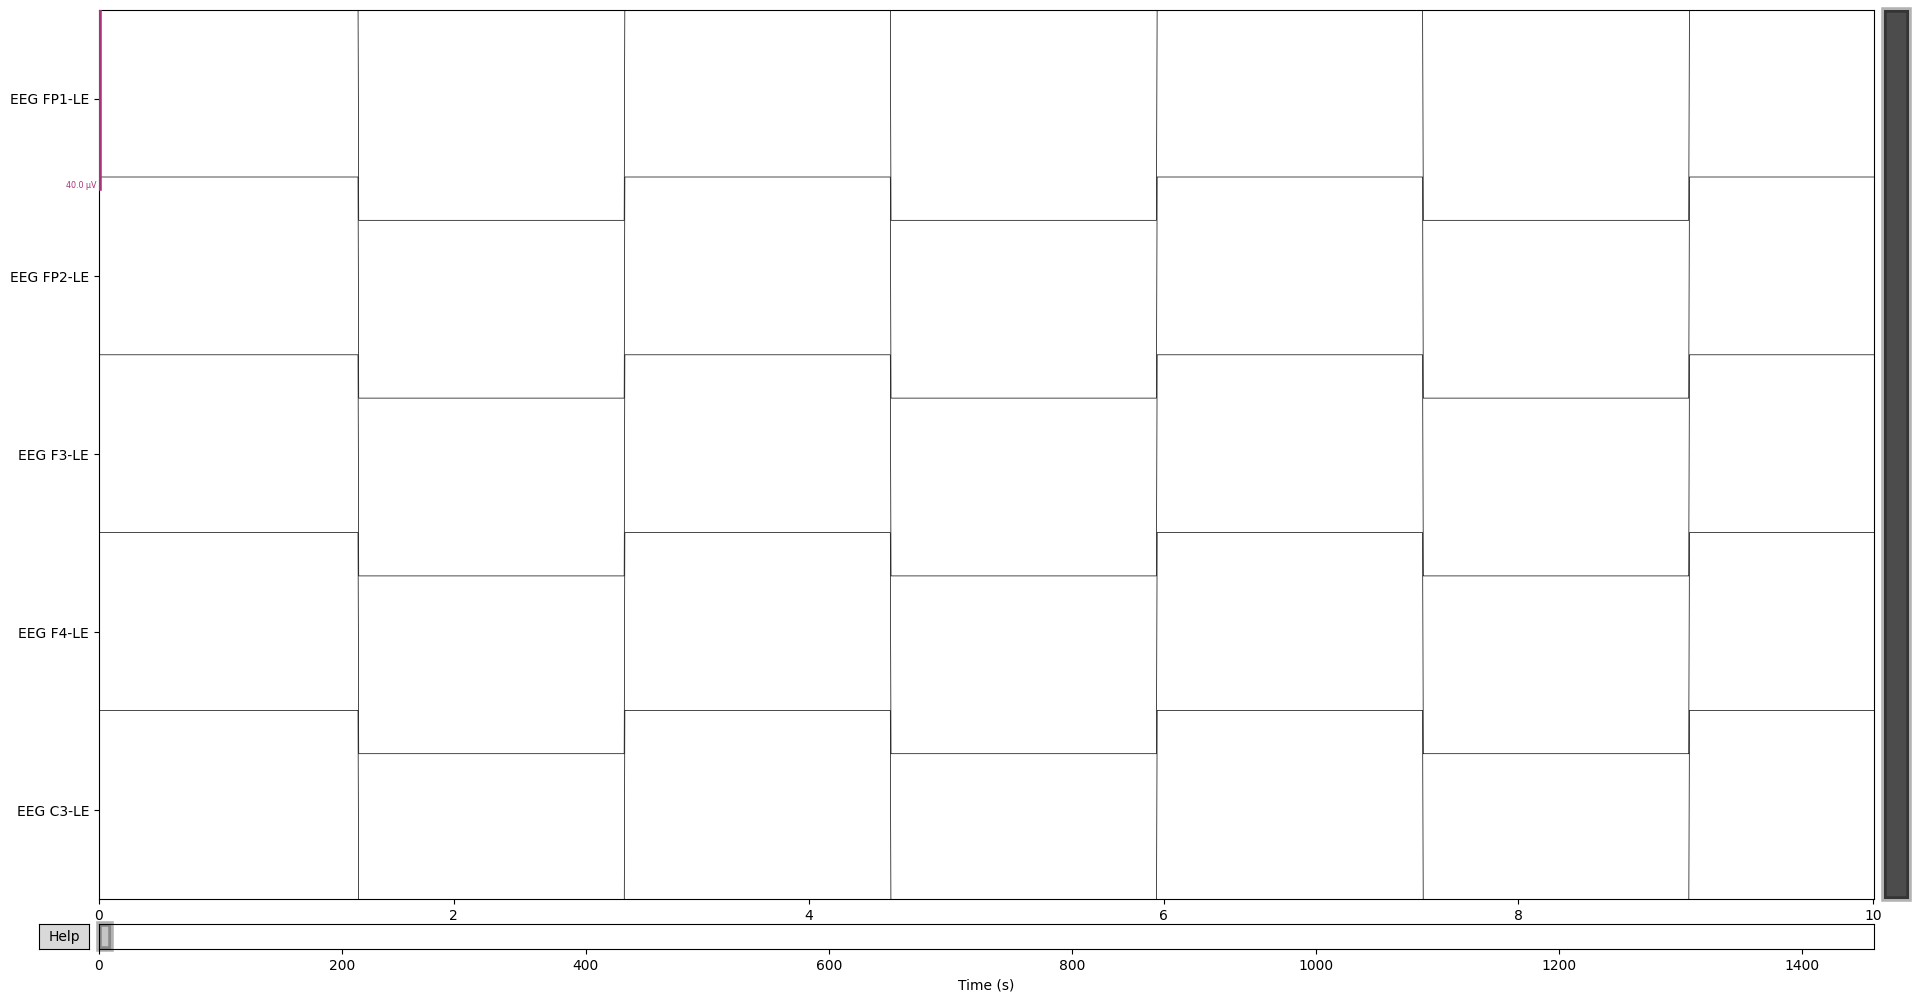

In [199]:
# Plot raw data
raw.plot()

Effective window size : 8.192 (s)


C:\Users\loicl\AppData\Local\Temp\ipykernel_52216\854838781.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd().plot()


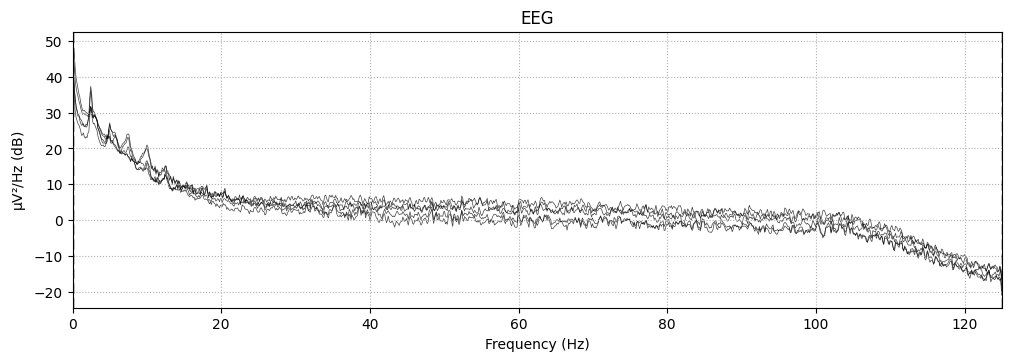

In [200]:
# Plot Power Spectral Density
raw.compute_psd().plot()

In [212]:
raw.notch_filter(60)  # 60 Hz notch filter
raw.filter(None, 90, fir_design="firwin")  # 90 Hz lowpass filter
# raw = mne.channels.combine_channels(raw, dict(new=[0, 1, 2, 3, 4]), method="mean")

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 90 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 90.00 Hz
- Upper transition bandwidth: 22.50 Hz (-6 dB cutoff frequency: 101.25 Hz)
- Filter length: 37 sa

Measurement date,"September 05, 2006 11:36:02 GMT"
Experimenter,Unknown
Participant,00000675
Digitized points,Not available
Good channels,5 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.00 Hz
Lowpass,90.00 Hz


# Create and Apply Annotations


## Create Labels


In [213]:
def format_annotations(annotations_file):
    annotations_list = []
    with open(annotations_file, "r") as f:
        for i, v in enumerate(f.readlines()):
            if i >= 2:
                row = v.split(" ")
                row.remove(row[-1])
                annotations_list.append(row)
    return annotations_list

In [214]:
# Import annotations from annotation file
annotations_from_file = format_annotations(
    annotations_file=f"processed_data/absence/annotations/{seizure_idx+1}/annot.tse"
)
annotations_from_file

[['0.0000', '115.4120', 'bckg'],
 ['115.4120', '119.7120', 'absz'],
 ['119.7120', '155.7120', 'bckg'],
 ['155.7120', '160.6120', 'absz'],
 ['160.6120', '168.2120', 'bckg'],
 ['168.2120', '169.9120', 'absz'],
 ['169.9120', '181.3120', 'bckg'],
 ['181.3120', '185.1120', 'absz'],
 ['185.1120', '205.4120', 'bckg'],
 ['205.4120', '210.2120', 'absz'],
 ['210.2120', '232.1120', 'bckg'],
 ['232.1120', '234.1120', 'absz'],
 ['234.1120', '244.3120', 'bckg'],
 ['244.3120', '246.3120', 'absz'],
 ['246.3120', '251.5120', 'bckg'],
 ['251.5120', '254.3120', 'absz'],
 ['254.3120', '255.2120', 'bckg'],
 ['255.2120', '256.6120', 'absz'],
 ['256.6120', '313.4120', 'bckg'],
 ['313.4120', '319.7120', 'absz'],
 ['319.7120', '554.7680', 'bckg'],
 ['554.7680', '558.9680', 'absz'],
 ['558.9680', '777.1240', 'bckg'],
 ['777.1240', '783.6240', 'absz'],
 ['783.6240', '1025.0633', 'bckg'],
 ['1025.0633', '1028.2120', 'absz'],
 ['1028.2120', '1034.0120', 'bckg'],
 ['1034.0120', '1037.3120', 'absz'],
 ['1037.3120', 

Collect beginning time and duration of each label


In [215]:
annotation_times = [[], [], []]

for i, v in enumerate(annotations_from_file):
    if v[2] == "bckg":
        annotation_times[0].append(float(v[0]))
        annotation_times[1].append(float(v[1]) - float(v[0]))
        annotation_times[2].append("0")
    elif v[2] == "absz":
        annotation_times[0].append(float(v[0]))
        annotation_times[1].append(float(v[1]) - float(v[0]))
        annotation_times[2].append("1")

Apply annotations to the data


Used Annotations descriptions: ['0', '1']


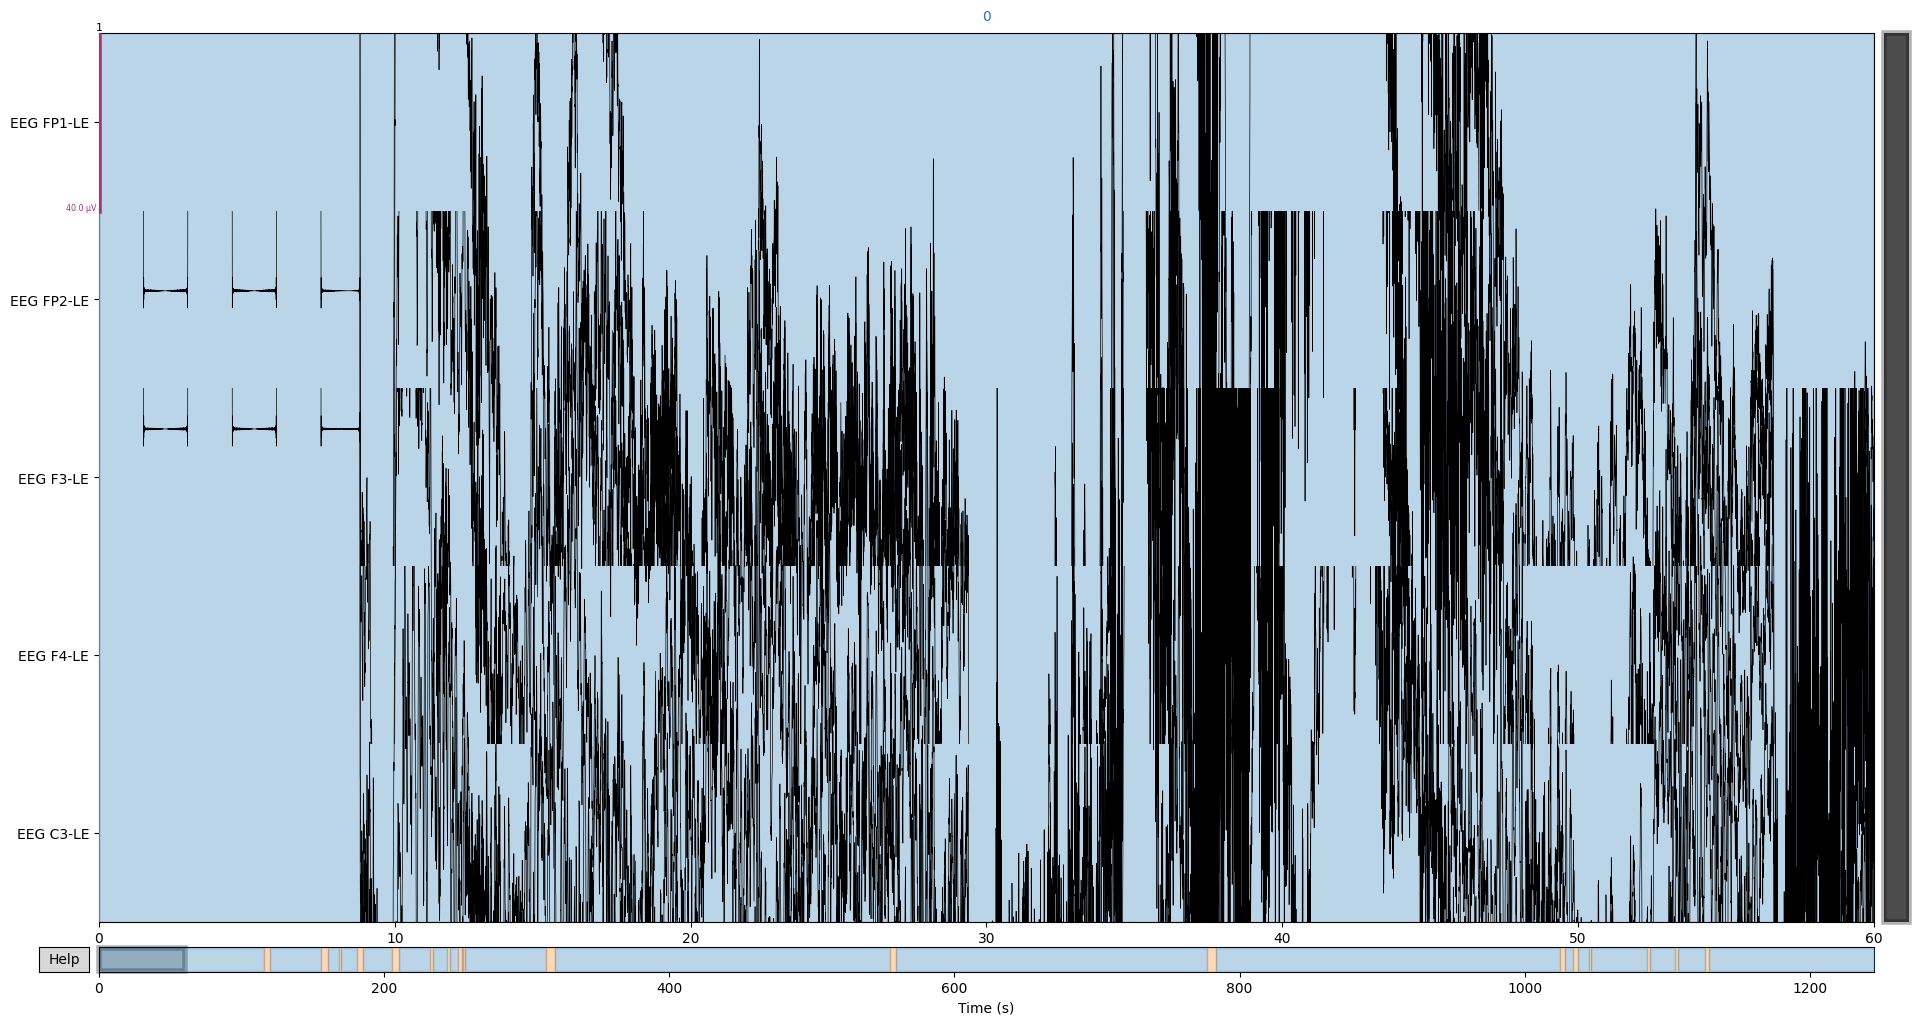

In [216]:
set_annotations = mne.Annotations(
    annotation_times[0], annotation_times[1], annotation_times[2]
)
raw.set_annotations(set_annotations)
events, event_id = mne.events_from_annotations(raw)

raw.plot(events=events, start=0, duration=60, color={"0": "blue", "1": "red"})

## Split into Epochs/Windows


In [217]:
epoch_duration = 4
epoch_overlap = 2
epochs = mne.make_fixed_length_epochs(
    raw, duration=epoch_duration, overlap=epoch_overlap
)

epochs_vector = epochs.get_data()

Not setting metadata
621 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 621 events and 1000 original time points ...
0 bad epochs dropped


Apply labels based on raw annotations


In [218]:
labels_list = [None] * len(epochs.events)
print(raw.annotations.description)
for i, v in enumerate(epochs.events):
    epoch_time_start = v[0] / 250
    epoch_time_end = epoch_time_start + epoch_duration
    epoch_range = list(range(math.floor(epoch_time_start), math.floor(epoch_time_end)))

    onset_list = []

    for j, k in enumerate(raw.annotations.onset):
        label_time_start = k
        label_time_end = k + (raw.annotations.duration[j])
        label_range = list(
            range(math.floor(label_time_start), math.floor(label_time_end))
        )

        count_in = 0
        count_out = 0

        for l in epoch_range:
            if l in label_range:
                count_in += 1
            else:
                count_out += 1

        onset_list.append(count_in / (count_in + count_out))

    for m, b in enumerate(onset_list):
        if b > 0.4 and (m % 2 != 0):
            max_inclusion_idx = m
            break
        if b == max(onset_list):
            max_inclusion_idx = m

    # print(onset_list)

    labels_list[i] = raw.annotations.description[max_inclusion_idx]

['0' '1' '0' '1' '0' '1' '0' '1' '0' '1' '0' '1' '0' '1' '0' '1' '0' '1'
 '0' '1' '0' '1' '0' '1' '0' '1' '0' '1' '0' '1' '0' '1' '0' '1' '0' '1'
 '0']


## Save Data

Save data to npy binary files.


In [219]:
epochs_vector = epochs.get_data()

which_folder = "five_channels_improved_labels"

epochs_vector_filepath = (
    f"processed_data/absence/{which_folder}/{seizure_idx+1}/absence_data.npy"
)
epochs_labels_filepath = (
    f"processed_data/absence/{which_folder}/{seizure_idx+1}/absence_data_labels.npy"
)

np.save(epochs_vector_filepath, epochs_vector)
np.save(epochs_labels_filepath, labels_list)

Using data from preloaded Raw for 621 events and 1000 original time points ...


In [156]:
# with open(f"processed_data/absence/{which_folder}/epochs_files.csv", "w", newline='') as f:
#     writer = csv.writer(f)
#     writer.writerow(["data", "labels"])

In [220]:
with open(
    f"processed_data/absence/{which_folder}/epochs_files.csv", "a", newline=""
) as f:
    writer = csv.writer(f)
    writer.writerow([epochs_vector_filepath, epochs_labels_filepath])